In [1]:
import sys
import os

# Adiciona o diretório src ao sys.path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Importa os módulos
from data_fetching import fetch_inmet_data

In [14]:
import pandas as pd
import geopandas as gpd
import requests
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.pyplot as plt

# Temperatura ao decorrer dos anos

In [2]:
# Recuperando os dados das estações dentro da Caatinga nos anos de 2000 a 2022
df_meta_dados = fetch_inmet_data([2000,2001,2002,2003,2004,2005,2006,2007,2008,
                                  2009,2010,2011,2012,2013,2014,2015,2016,2017,
                                  2018,2019,2020,2021,2022])
# Salvar os dados em um arquivo CSV
df_meta_dados.to_csv('../dados/df_meta_dados_serie.csv', index=False)

Downloading: 100%|██████████| 10566120/10566120 [53:52<00:00, 3268.40rows/s]


In [22]:
df_meta_dados = pd.read_csv('../dados/df_meta_dados_serie.csv')
df_meta_dados.head()

,ano,mes,data,hora,id_estacao,precipitacao_total,pressao_atm_hora,pressao_atm_max,pressao_atm_min,radiacao_global,...,temperatura_max,temperatura_min,temperatura_orvalho_max,temperatura_orvalho_min,umidade_rel_max,umidade_rel_min,umidade_rel_hora,vento_direcao,vento_rajada_max,vento_velocidade
0,2009,11,2009-11-05,20:00:00,A358,0.0,991.1,991.2,991.1,639.4,...,37.4,35.5,12.5,11.2,25.0,22.0,24.0,51.0,5.0,1.9
1,2017,10,2017-10-23,19:00:00,A365,0.0,971.9,972.1,971.8,1915.8,...,37.3,36.3,7.9,6.4,17.0,16.0,16.0,112.0,8.7,3.1
2,2017,3,2017-03-05,20:00:00,A366,0.0,954.8,954.8,954.6,1276.4,...,34.4,33.7,12.1,9.2,26.0,22.0,22.0,178.0,7.5,4.0
3,2015,9,2015-09-20,22:00:00,A343,0.0,984.2,984.2,983.8,NaN,...,35.6,34.2,8.4,7.4,21.0,18.0,21.0,128.0,5.4,3.2
4,2015,8,2015-08-29,23:00:00,A337,0.0,956.7,956.7,955.9,0.0,...,28.8,27.0,2.7,1.9,20.0,19.0,20.0,127.0,4.4,1.3


In [23]:
df_meta_dados['ano'].unique()

array([2009, 2017, 2015, 2016, 2021, 2010, 2014, 2018, 2012, 2022, 2020,
       2019, 2011, 2013, 2008, 2006, 2004, 2003, 2005, 2007], dtype=int64)

# Segmentações ao decorrer dos anos

In [9]:
# Diretório onde os arquivos serão salvos
save_dir = '../dados/segmentacoes'

# Lista de anos
years = range(2000, 2023)  # De 2000 até 2022

# Loop para baixar os arquivos
for year in years:
    # Construindo a URL para o ano atual
    url = f'https://storage.googleapis.com/mapbiomas-public/initiatives/brasil/collection_8/lclu/coverage/brasil_coverage_{year}.tif'
    
    # Nome do arquivo local onde o TIF será salvo
    local_filename = f'{save_dir}brasil_coverage_{year}.tif'

    # Fazendo a requisição para baixar o arquivo
    response = requests.get(url)
    
    # Verificando se a requisição foi bem-sucedida
    if response.status_code == 200:
        # Garantindo que o diretório exista
        os.makedirs(save_dir, exist_ok=True)
        
        # Escrevendo o conteúdo do arquivo baixado no arquivo local
        with open(local_filename, 'wb') as file:
            file.write(response.content)
        print(f'Arquivo {local_filename} baixado e salvo com sucesso.')
    else:
        print(f'Falha ao baixar o arquivo para o ano {year}.')

Arquivo ../dados/segmentacoesbrasil_coverage_2000.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2001.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2002.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2003.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2004.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2005.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2006.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2007.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2008.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2009.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2010.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2011.tif baixado e salvo com sucesso.
Arqu

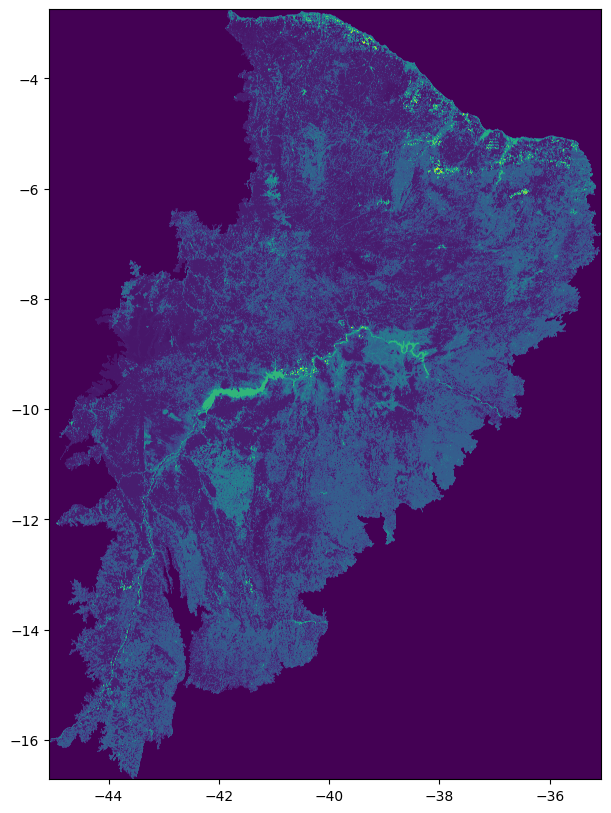

<Axes: >

In [15]:
# Caminho para o shapefile dos biomas
biomes_shp = '../dados/Biomas_250mil/lm_bioma_250.shp'

# Carregar o shapefile dos biomas
biomes = gpd.read_file(biomes_shp)

# Filtrar para obter apenas a Caatinga
caatinga = biomes[biomes['Bioma'] == 'Caatinga']

# Caminho para o arquivo GeoTiff
raster_path = '../dados/segmentacoes/segmentacoesbrasil_coverage_2000.tif'

# Carregar o arquivo GeoTiff e aplicar a máscara da Caatinga
with rasterio.open(raster_path) as src:
    out_image, out_transform = mask(src, caatinga.geometry, crop=True, nodata=0)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform,
                     "nodata": 0})

# Plotar a imagem recortada
plt.figure(figsize=(10, 10))
show(out_image, transform=out_transform, cmap='viridis')